In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
with open('cam_mtx.pickle','rb') as handle:
    mtx=pickle.load(handle)
    print('camera matrix loaded')
with open('dist_coeffs.pickle','rb') as handle:
    dist=pickle.load(handle)
    print('distortion coefficients loaded')

camera matrix loaded
distortion coefficients loaded


In [3]:
def undistort(img,mtx,dist,visualize=False):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    if visualize:
        plt.imshow(undist)
        plt.title('undistorted image')
    return undist

In [4]:
def pipeline(img,mtx,dist,s_thresh=(170,255),sx_thresh=(20,100),sy_thresh=(20,100),visualize=False):
    undistorted_img=undistort(img,mtx,dist)
    
    hls_img=cv2.cvtColor(img,cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel=hls_img[:,:,1]
    s_channel=hls_img[:,:,2]
    
    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])]=1
    
    grad_x=cv2.Sobel(l_channel,cv2.CV_64F,1,0)
    abs_grad_x=np.absolute(grad_x)
    scaled_grad_x=(255*abs_grad_x/np.max(abs_grad_x))
    grad_x_binary=np.zeros_like(scaled_grad_x)
    grad_x_binary[(scaled_grad_x>=sx_thresh[0])&(scaled_grad_x<=sx_thresh[1])]=1
    
    grad_y=cv2.Sobel(l_channel,cv2.CV_64F,0,1)
    abs_grad_y=np.absolute(grad_y)
    scaled_grad_y=(255*abs_grad_y/np.max(abs_grad_y))
    grad_y_binary=np.zeros_like(scaled_grad_y)
    grad_y_binary[(scaled_grad_y>=sy_thresh[0])&(scaled_grad_y<=sy_thresh[1])]=1
    
    combined_binary_img=np.zeros_like(grad_x_binary)
    combined_binary_img[((grad_x_binary==1)&(grad_y_binary==1))|(s_binary==1)]=1
    
    if visualize:
        combined_color_img=np.uint8(np.dstack((np.zeros_like(s_binary),s_binary,grad_x_binary))*255)
        plt.imshow(combined_color_img)
        plt.title('combined color image')
        
    return combined_binary_img

In [5]:
def region_of_interest(img,vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
def fit_lanes(warped_binary_img,found_lanes_history,left_fit_history,right_fit_history):
    if not found_lanes_history:
        histogram=np.sum(warped_binary_img[warped_binary_img.shape[0]//2:,:],axis=0)
        midpoint=np.int(histogram.shape[0]/2)
        leftx_base=np.argmax(histogram[:midpoint])
        rightx_base=np.argmax(histogram[midpoint:])+midpoint
        leftx_current=leftx_base
        rightx_current=rightx_base
        
    nwindows=9
    window_height=np.int(warped_binary_img.shape[0]/nwindows)
    nonzero=warped_binary_img.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    margin=100
    minpix=50
    
    left_lane_inds=[]
    right_lane_inds=[]
    if found_lanes_history:
        for window in range(nwindows):
            win_y_low=warped_binary_img.shape[0]-(window+1)*window_height
            win_y_high=warped_binary_img.shape[0]-window*window_height
            y_=(win_y_low+win_y_high)/2
            leftx_current=left_fit_history[0]*y_**2+left_fit_history[1]*y_+left_fit_history[2]
            win_xleft_low=leftx_current-margin
            win_xleft_high=leftx_current+margin
            rightx_current=right_fit_history[0]*y_**2+right_fit_history[1]*y_+right_fit_history[2]
            win_xright_low=rightx_current-margin
            win_xright_high=rightx_current+margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
    else:
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low=warped_binary_img.shape[0]-(window+1)*window_height
            win_y_high=warped_binary_img.shape[0]-window*window_height
            win_xleft_low=leftx_current-margin
            win_xleft_high=leftx_current+margin
            win_xright_low=rightx_current-margin
            win_xright_high=rightx_current+margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if leftx.size==0 or lefty.size==0:
        found_lanes=False
    else:
        found_lanes=True

    # Fit a second order polynomial to each
    left_fit=[]
    right_fit=[]
    if found_lanes:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    return found_lanes,left_fit,right_fit

In [7]:
def calculate_ROC(A,B,y): 
    return ((1+((2*A*y+B)**2))**1.5)/(2*A)

In [8]:
def find_lanes(img,mtx,dist,s_thresh=(170,255),sx_thresh=(20,100),sy_thresh=(20,100),visualize=False):
    global left_fit_previous,right_fit_previous,found_lanes_previous
    
    undistorted_img=undistort(img,mtx,dist,visualize)
    combined_binary_img=pipeline(img,mtx,dist,s_thresh,sx_thresh,sy_thresh,visualize)
    
    imshape=combined_binary_img.shape
    roi_vertices=np.array([[(0,imshape[0]),(imshape[1]/2-100,imshape[0]/2+100),(imshape[1]/2+100,imshape[0]/2+100),
                            (imshape[1],imshape[0])]],dtype=np.int32)
    binary_roi=region_of_interest(combined_binary_img,roi_vertices)
    
    src_pts=np.float32(roi_vertices)
    dst_pts=np.float32([[(0,imshape[0]),(0,0),(imshape[1],0),(imshape[1],imshape[0])]])
    M=cv2.getPerspectiveTransform(src_pts,dst_pts)
    Minv=cv2.getPerspectiveTransform(dst_pts,src_pts)
    warped_binary_roi=cv2.warpPerspective(binary_roi,M,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
    
    found_lanes,left_lane_fit,right_lane_fit=fit_lanes(warped_binary_roi,found_lanes_previous,
                                                       left_fit_previous,right_fit_previous)
    if not found_lanes:
         found_lanes,left_lane_fit,right_lane_fit=fit_lanes(warped_binary_roi,False,
                                                       [],[])
    if found_lanes and found_lanes_previous:
        for i in range(3):
            left_lane_fit[i]=0.1*left_lane_fit[i]+0.9*left_fit_previous[i]
            right_lane_fit[i]=0.1*right_lane_fit[i]+0.9*right_fit_previous[i]
    
    if found_lanes:
        left_fit_previous,right_fit_previous,found_lanes_previous=left_lane_fit,right_lane_fit,found_lanes
        
        ploty=np.linspace(0,warped_binary_roi.shape[0]-1,warped_binary_roi.shape[0])
        left_fitx=left_lane_fit[0]*ploty**2+left_lane_fit[1]*ploty+left_lane_fit[2]
        right_fitx=right_lane_fit[0]*ploty**2+right_lane_fit[1]*ploty+right_lane_fit[2]

        warp_zero=np.zeros_like(warped_binary_roi).astype(np.uint8)
        color_warp=np.dstack((warp_zero, warp_zero,warp_zero))
        pts_left=np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))

        unwarped_out_img=cv2.warpPerspective(color_warp,Minv,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
        result = cv2.addWeighted(undistorted_img, 1, unwarped_out_img, 0.3, 0)
        
        offset=((left_fitx[-1]+right_fitx[-1])/2)-(imshape[1]/2)
        offset_info='offset from lane center: '+str(np.round(offset,2))
        
        ROC_left=calculate_ROC(left_lane_fit[0],left_lane_fit[1],imshape[0])
        ROC_right=calculate_ROC(right_lane_fit[0],right_lane_fit[1],imshape[0])
        ROC_avg=(ROC_left+ROC_right)/2
        ROC_info='radius of curvature of lane: '+str(np.round(ROC_avg,2))
    elif found_lanes_previous:
        ploty=np.linspace(0,warped_binary_roi.shape[0]-1,warped_binary_roi.shape[0])
        left_fitx=left_fit_previous[0]*ploty**2+left_fit_previous[1]*ploty+left_fit_previous[2]
        right_fitx=right_fit_previous[0]*ploty**2+right_fit_previous[1]*ploty+right_fit_previous[2]

        warp_zero=np.zeros_like(warped_binary_roi).astype(np.uint8)
        color_warp=np.dstack((warp_zero, warp_zero,warp_zero))
        pts_left=np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))

        unwarped_out_img=cv2.warpPerspective(color_warp,Minv,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
        result = cv2.addWeighted(undistorted_img, 1, unwarped_out_img, 0.3, 0)
        
        offset=((left_fitx[-1]+right_fitx[-1])/2)-(imshape[1]/2)
        offset_info='offset from lane center: '+str(np.round(offset,2))
        
        ROC_left=calculate_ROC(left_fit_previous[0],left_fit_previous[1],imshape[0])
        ROC_right=calculate_ROC(right_fit_previous[0],right_fit_previous[1],imshape[0])
        ROC_avg=(ROC_left+ROC_right)/2
        ROC_info='radius of curvature of lane: '+str(np.round(ROC_avg,2))
    else:
        result=undistorted_img.copy()
        offset_info='offset from lane center: '
        ROC_info='radius of curvature of lane: '
    
    font = cv2.FONT_HERSHEY_COMPLEX 
    cv2.putText(result,offset_info,(30,60),font,1,(0,255,0),2)
    cv2.putText(result,ROC_info,(30,90),font,1,(0,255,0),2)
        
    return left_lane_fit,right_lane_fit,result

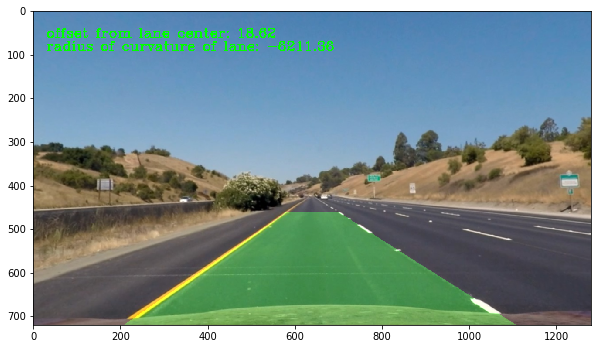

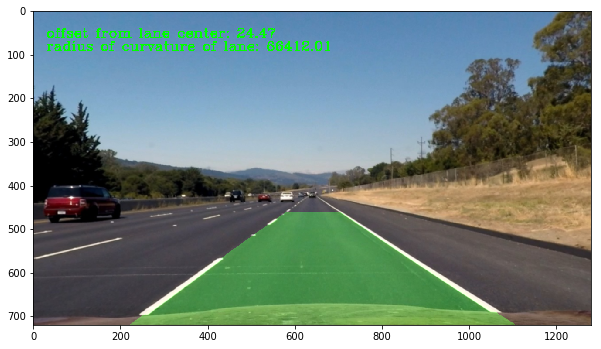

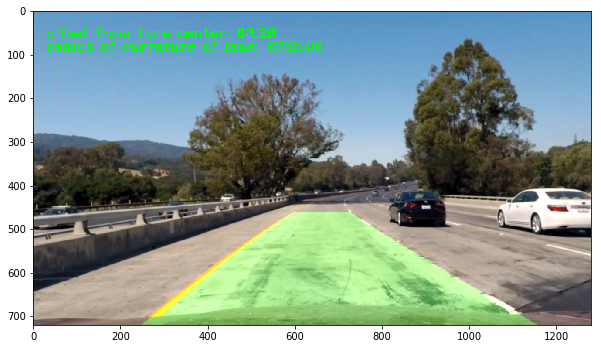

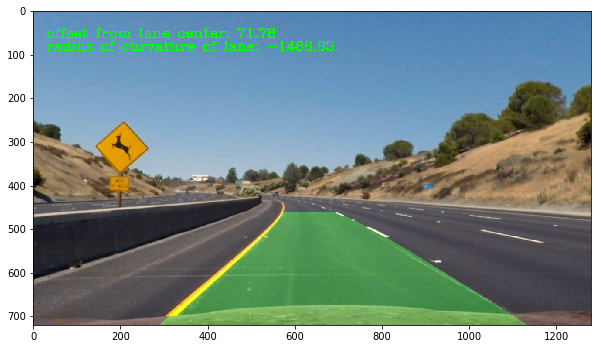

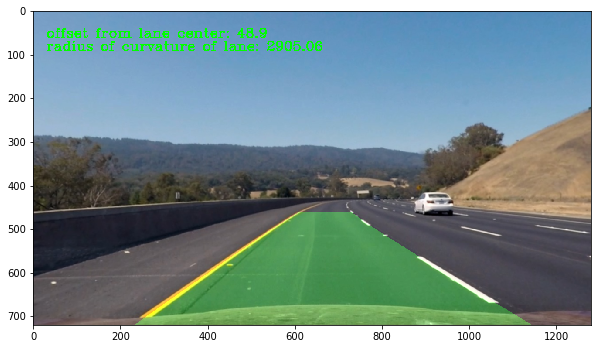

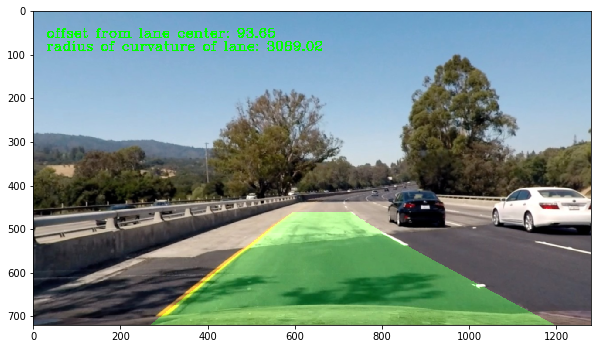

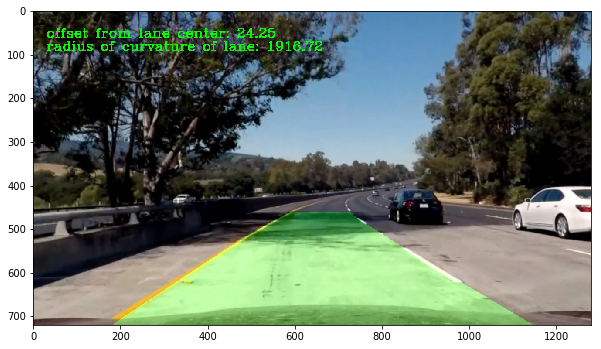

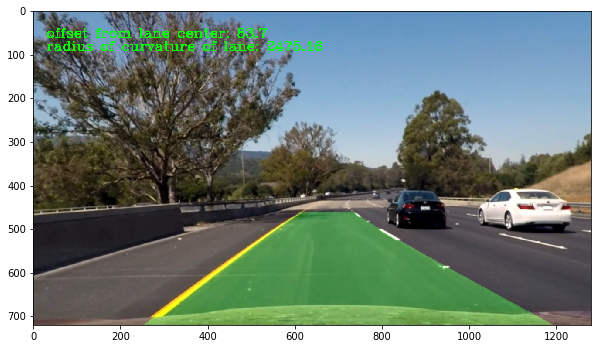

In [9]:
import os

test_img_path='./test_images/'
img_names=os.listdir(test_img_path)
for img_name in img_names:
    img=cv2.imread(test_img_path+img_name)
    img=cv2.GaussianBlur(img,(3,3),0)
    left_fit_previous=[]
    right_fit_previous=[]
    found_lanes_previous=False
    _,_,out=find_lanes(img,mtx,dist)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))

### Following portion of code is for generating images for writeup

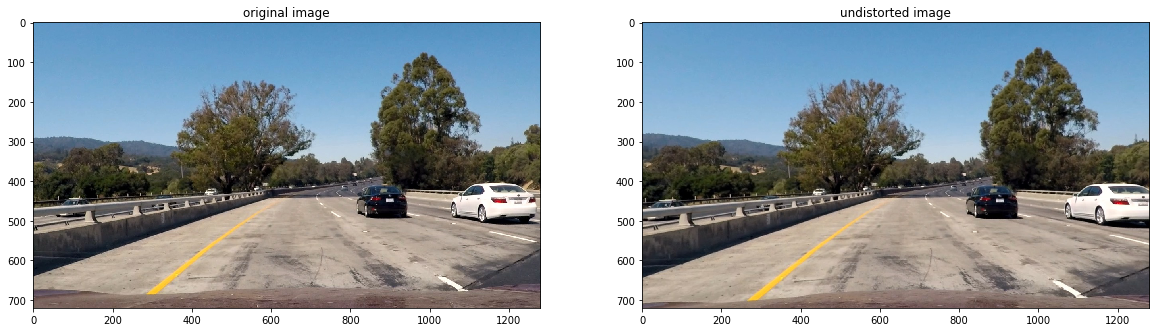

In [20]:
test_img=cv2.imread('./test_images/test1.jpg')
undistorted_test_img=undistort(test_img,mtx,dist)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(undistorted_test_img,cv2.COLOR_BGR2RGB))
plt.title('undistorted image')

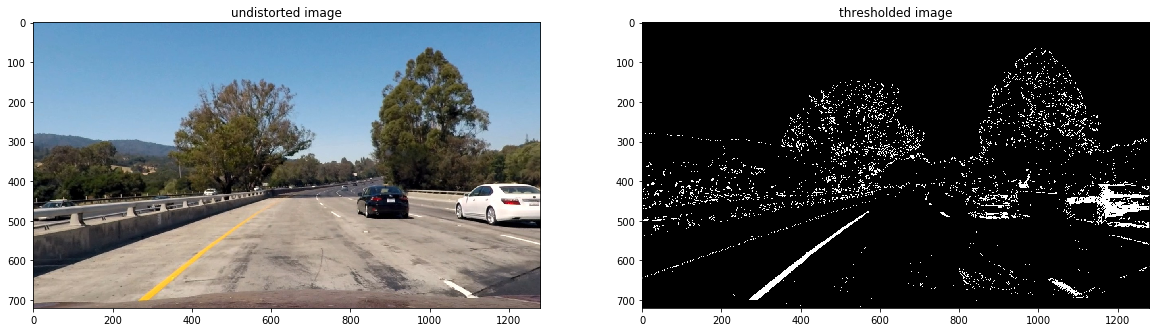

In [22]:
thresholded_test_img=pipeline(undistorted_test_img,mtx,dist)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(undistorted_test_img,cv2.COLOR_BGR2RGB))
plt.title('undistorted image')
plt.subplot(1,2,2)
plt.imshow(thresholded_test_img,cmap='gray')
plt.title('thresholded image')

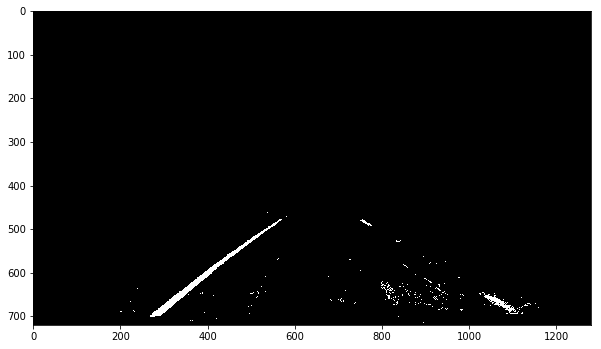

In [27]:
imshape=thresholded_test_img.shape
roi_vertices_test=np.array([[(0,imshape[0]),(imshape[1]/2-100,imshape[0]/2+100),(imshape[1]/2+100,imshape[0]/2+100),
                        (imshape[1],imshape[0])]],dtype=np.int32)
binary_roi_test=region_of_interest(thresholded_test_img,roi_vertices_test)
plt.figure(figsize=(10,10))
plt.imshow(binary_roi_test,cmap='gray')

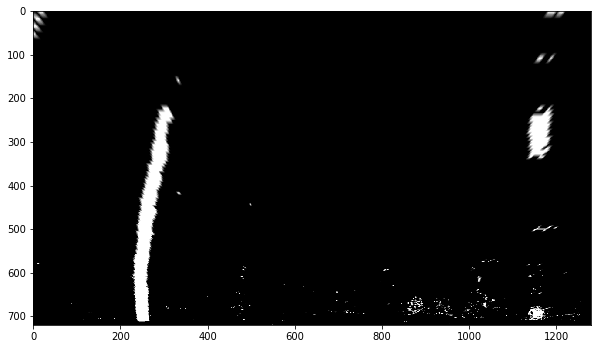

In [28]:
src_pts_test=np.float32(roi_vertices_test)
dst_pts_test=np.float32([[(0,imshape[0]),(0,0),(imshape[1],0),(imshape[1],imshape[0])]])
M_test=cv2.getPerspectiveTransform(src_pts_test,dst_pts_test)
warped_binary_test=cv2.warpPerspective(binary_roi_test,M_test,(imshape[1],imshape[0]),flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(warped_binary_test,cmap='gray')

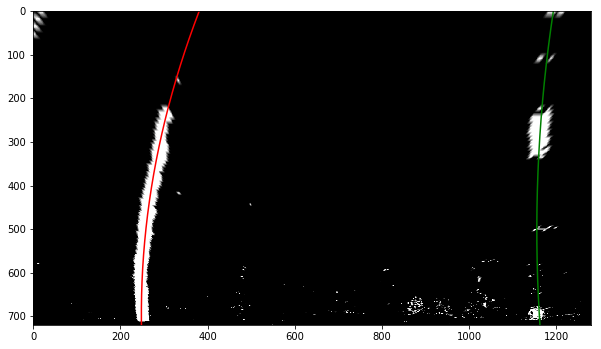

In [29]:
found_lanes_test,left_lane_fit_test,right_lane_fit_test=fit_lanes(warped_binary_test,False,[],[])
ploty_test=np.linspace(0,warped_binary_test.shape[0]-1,warped_binary_test.shape[0])
left_fitx_test=left_lane_fit_test[0]*ploty_test**2+left_lane_fit_test[1]*ploty_test+left_lane_fit_test[2]
right_fitx_test=right_lane_fit_test[0]*ploty_test**2+right_lane_fit_test[1]*ploty_test+right_lane_fit_test[2]

plt.figure(figsize=(10,10))
plt.imshow(warped_binary_test,cmap='gray')
plt.plot(left_fitx_test,ploty_test,color='red')
plt.plot(right_fitx_test,ploty_test,color='green')

### Following code is to find lanes in videos

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")

def process_frames(img):
    img=cv2.GaussianBlur(img,(3,3),0)
    _,_,out=find_lanes(img,mtx,dist)
    return out

In [12]:
white_output='test_videos_output/project_video.mp4'
clip1=VideoFileClip("./project_video.mp4")

left_fit_previous=[]
right_fit_previous=[]
found_lanes_previous=False

white_clip=clip1.fl_image(process_frames) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [19:15<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 19min 21s


In [13]:
white_output='test_videos_output/challenge_video.mp4'
clip1=VideoFileClip("./challenge_video.mp4")

left_fit_previous=[]
right_fit_previous=[]
found_lanes_previous=False

white_clip=clip1.fl_image(process_frames) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [07:59<00:00,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 8min 8s
